# Notebook to make Figure 4

In [ ]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import importlib
import json
import h5ify
import os
import tqdm
import imageio

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
style.use('../utils/plotting.mplstyle')
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('muted')
cp2 = sns.color_palette('pastel')
cp3 = sns.color_palette('dark')

import sys
sys.path.append('../utils')
import plotting_functions as pf

# where data is saved
data_dir = '../data/different_total_masses/'

### Setup

Load data

In [1]:
# Load in posteriors
posteriors_dict = h5ify.load(data_dir+'posteriors_different_total_masses.h5'),

# Load in the prior
prior_dict = h5ify.load(data_dir+'../real_and_maxL_GW190521/prior.h5')

# Load in the signals' parameters
injected_params_dict = h5ify.load(data_dir+'parameters_different_total_masses.h5')

# Load in the signals' strain
diff_mass_injs = h5ify.load(data_dir+'waveforms_different_total_masses.h5')

# Load in the accumulated SNR over time 
snrs_dict = h5ify.load(data_dir+'accumulated_SNR_different_total_masses.h5')

Setup plotting aesthetics

In [2]:
# Which total masses to plot
masses = [80, 100, 120, 270, 500]
masses_to_plot = [f'total mass {Mtot}' for Mtot in masses]

# Associated colors and labels
colors = [cp3[6], cp2[6],  'mediumpurple', cp3[0], cp2[0]]
labels = [fr'$M = {Mtot} \, M_\odot$' for Mtot in masses]

# Which cycles to plot
cycles_to_plot = ['-1.0', '0.0', '1.0', '1.5', '2.0']

# Get the prior samples for chi_p
chip_prior = np.asarray(prior_dict['chi_p'])

# For text on figures 
bbox_dict=dict(facecolor='white', edgecolor='silver', boxstyle='round')

# For posterior/prior histograms
chip_ymax = 3.5
hist_bins = np.linspace(pf.xlims['chi_p'][0],  pf.xlims['chi_p'][-1], 30)
prior_hist_kws = dict(histtype='step', density=True, bins=hist_bins, lw=1.5, color='gray', ls=':', zorder=0)

### Make Figure

First panel

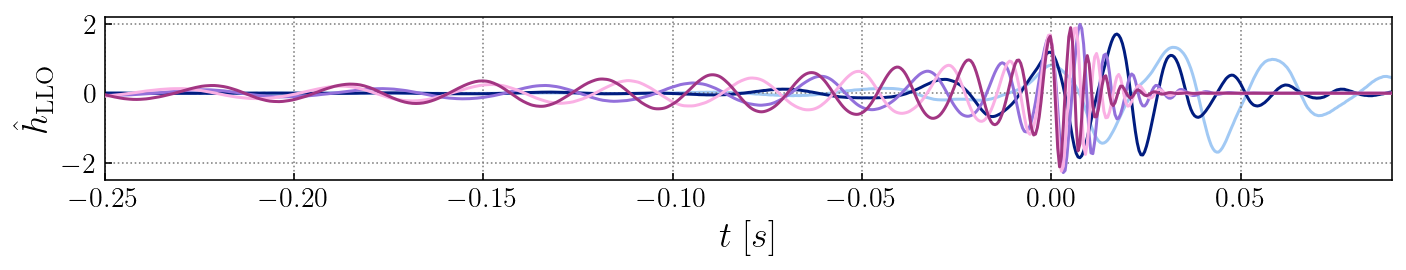

In [3]:
plt.figure(figsize = (pf.DEFAULT_FIG_WIDTH, 1.5))

i=5
for m,c,l in zip(masses_to_plot,colors,labels): 
    
    # injected
    times_s = np.asarray(diff_mass_injs[m]['time_dict']['L1']) - injected_params_dict[m]['L1_time']
    injected_wf = diff_mass_injs[m]['strain_wh']['L1']
    
    # plot
    plt.plot(times_s, injected_wf, color=c, label=l, zorder=i)
    i = i - 1
    
plt.xlim(-0.25,0.09)
plt.xlabel(r'$t$~[$s$]')
plt.ylabel(r'$\hat h_{\rm LLO}$')
plt.savefig('figure_04a.png', dpi=300, bbox_inches='tight')
plt.show()

Second panel

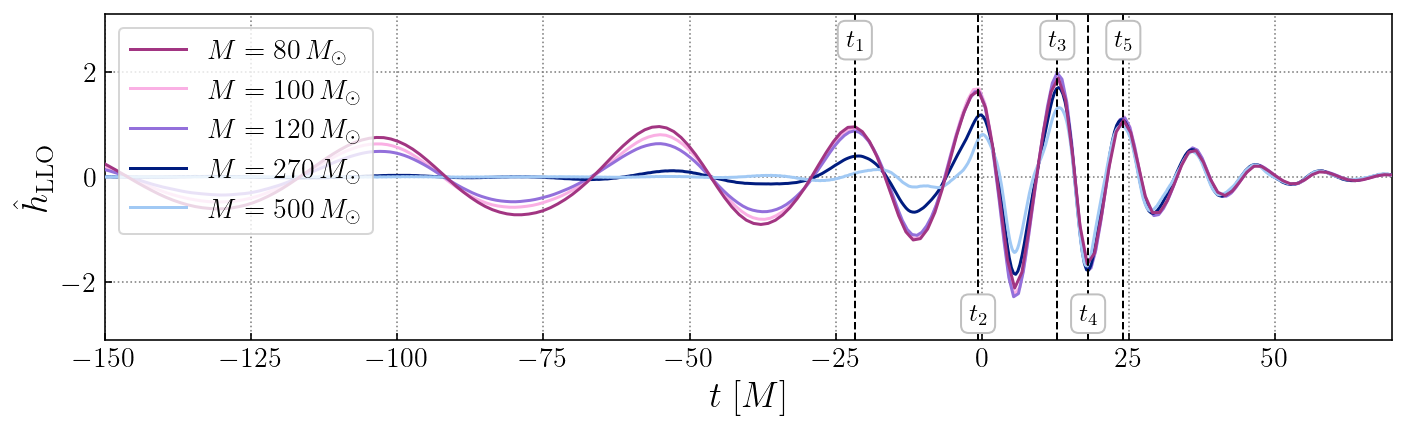

In [4]:
importlib.reload(pf)

CUTOFF_TIMES_M = []

plt.figure(figsize = (pf.DEFAULT_FIG_WIDTH, 3))

i=5
for m,c,l in zip(masses_to_plot,colors,labels): 
    
    # injected
    times_s = np.asarray(diff_mass_injs[m]['time_dict']['L1']) - injected_params_dict[m]['L1_time']
    injected_wf = diff_mass_injs[m]['strain_wh']['L1']
    
    # transform times
    mass = int(m[-3:])
    times_M = pf.transform_s_to_M(times_s, mass)
    
    # plot
    plt.plot(times_M, injected_wf, color=c, label=l, zorder=i)
    i = i - 1
    
   #  vertical lines at the cutoff times 
    for i,n in enumerate(cycles_to_plot):
        
        if '270' in m:
            
            t = pf.cycles_to_times_dict[m][n]
            tc_M = pf.transform_s_to_M(float(t), mass) # transform seconds -> M

            CUTOFF_TIMES_M.append(tc_M)
            
            plt.axvline(tc_M, color='k', ls='--', lw=1, zorder=6)
            
            x = int(i+1)
            tcut_lbl = fr'$t_{x}$'
            text_kws = dict(horizontalalignment='center', verticalalignment='center',fontsize=13, color='k', bbox=bbox_dict, zorder=7)
            yabs = 2.6
            y = -1*yabs if x%2==0 else yabs
            plt.text(tc_M, y, tcut_lbl, **text_kws)
    
plt.xlim(-150,70)
plt.ylim(-3.1,3.1)
plt.xlabel(r'$t$~[$M$]')
plt.ylabel(r'$\hat h_{\rm LLO}$')
plt.legend(loc='upper left', frameon=True)#
plt.savefig('figure_04b.png', dpi=300, bbox_inches='tight')
plt.show()

Third and fourth rows

<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
/local/simona.miller/ipykernel_2277167/2859295197.py:37: SyntaxWarning: invalid escape sequence '\c'
  ax.set_xlabel('$\chi_p$')


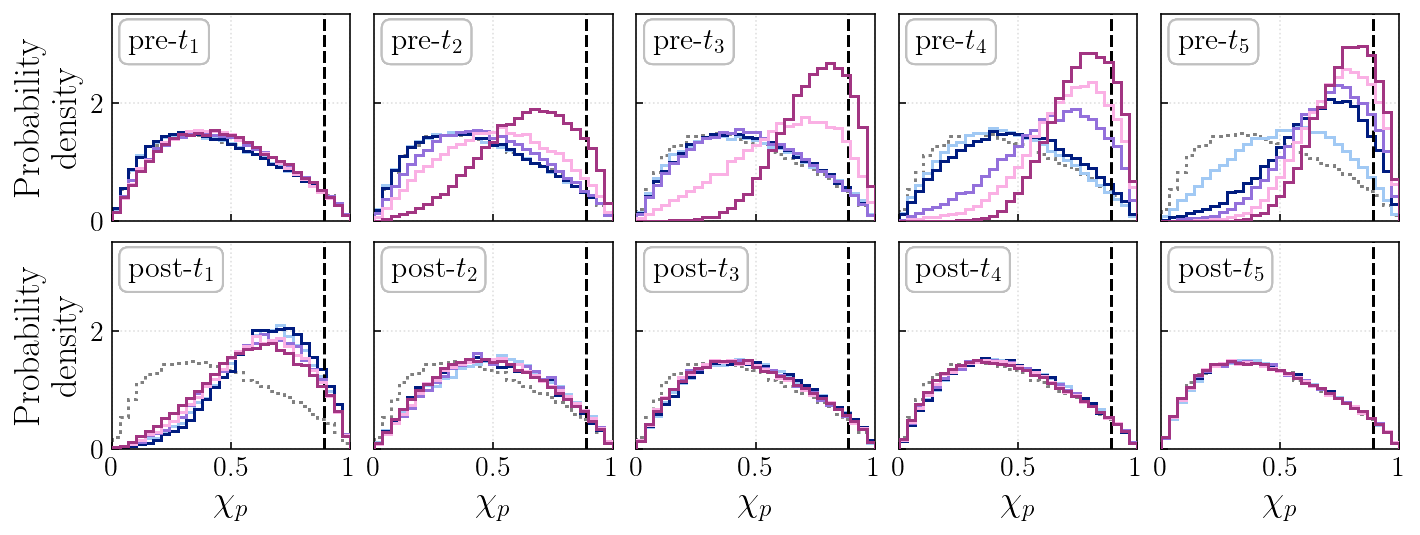

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize = (pf.DEFAULT_FIG_WIDTH, 4), sharex=True, sharey=True)

# cycle through cutoff times and masses
for i, cycle in enumerate(cycles_to_plot): 

    x = int(i+1)
    tcut_lbl = fr'$t_{x}$'

    for n, mtotal in enumerate(masses_to_plot): 

        color = colors[n]

        # plot chi-p posteriors
        for prepost, _axes in zip(['pre', 'post'], axes): 
            ax = _axes[i]

            t = pf.cycles_to_times_dict[mtotal][cycle]
            chip_posterior = posteriors_dict[0][mtotal][f'{prepost}_{t}']['chi_precessing']

            hist_kws = dict(histtype='step', density=True, bins=hist_bins, lw=1.5, color=color)

            p = 'chi_p'
            pf.plot_posterior(ax, chip_posterior, pf.xlims[p], chip_ymax, pf.params[p], **hist_kws, zorder=5-n)
            pf.plot_posterior(ax, chip_prior, pf.xlims[p], chip_ymax, pf.params[p], **prior_hist_kws)

            # plot true value
            ax.axvline(injected_params_dict[mtotal][p], color='k', lw=1.5, ls='--')

            # add label for run 
            ax.text(0.07, 0.93, fr'{prepost}-{tcut_lbl}', fontsize=15, bbox=bbox_dict,
                     transform=ax.transAxes, verticalalignment='top', horizontalalignment='left')
            
            ax.set_xlabel('')
            ax.set_ylabel('')

for ax in axes[1]:
    ax.set_xlabel('$\chi_p$')
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(['0', '0.5', '1'])
for ax in axes.T[0]:
    ax.set_ylabel('Probability\ndensity')
    
sp = 0.1
plt.subplots_adjust(hspace=sp, wspace=sp)

plt.savefig('figure_04c.png', dpi=300, bbox_inches='tight')
    
plt.show()

Bottom row

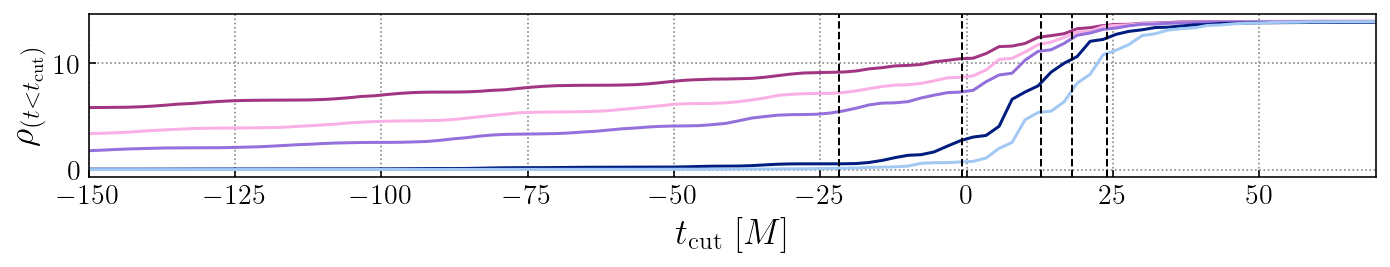

In [6]:
plt.figure(figsize = (pf.DEFAULT_FIG_WIDTH, 1.5))

for m,c,l in zip(masses_to_plot,colors,labels): 
    
    # plot
    plt.plot(snrs_dict['times_M'], snrs_dict[m], color=c, label=l)
    
for x in CUTOFF_TIMES_M: 
    plt.axvline(x, color='k', ls='--',  lw=1, zorder=5)

plt.xlim(-150,70)
plt.ylabel(r'$\rho_{(t<t_{\rm cut})} $')
plt.xlabel(r'$t_{\rm {cut}}$~[$M$]')
plt.savefig('figure_04d.png', dpi=300, bbox_inches='tight')
plt.show()